Port of `aes-int.py` into a Python3 module, an AES-128 analysis script initially developed by Greg d'Eon in the context of [tutorial CW305-3 (wiki)](https://wiki.newae.com/Tutorial_CW305-3_Clock_Glitching)

In [ ]:
#!/usr/bin/env python3

from Crypto.Cipher import AES
import matplotlib.pyplot as plt

class AesStates():
    def __init__(self, keysize=128, blocksize=128):
        # ------------------------------------------------------ Parameters for AES-128
        self.Nb = blocksize//32
        self.Nk = keysize//32
        self.Nr = 6 + max(self.Nb, self.Nk)

    # --------------------------------------------------------------- Lookup tables
    __s_box =     [
        0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
        0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
        0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
        0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
        0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
        0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
        0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
        0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
        0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
        0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
        0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
        0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
        0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
        0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
        0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
        0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ]

    __s_box_inv = [
        0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
        0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
        0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
        0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
        0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
        0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
        0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
        0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
        0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
        0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
        0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
        0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
        0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
        0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
        0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
        0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D
    ]

    __r_con = [
        0x00000000,    # Unused
        0x01000000,    # i = 1
        0x02000000,
        0x04000000,
        0x08000000,
        0x10000000,
        0x20000000,
        0x40000000,
        0x80000000,
        0x1b000000,
        0x36000000    # i = 10
        ]


    # --------------------------------------------------------------- Key expansion
    #Apply the s-box to each of the 4 bytes in a word
    def __sub_word(self, input):    
        output = 0
        for i in range(4):
            input_byte = input & 0xFF
            output_byte = self.__s_box[input_byte]
            output = output + (output_byte << (8 * i))
            input = input >> 8
        return output

    #Rotate a word, making a cyclic permutation
    def __rot_word(self, input):    
        return ((input << 8) + (input >> 24)) % (1 << 32)

    # Perform key expansion on the provided key using the value of Nk (above)
    def __expand_key(self, key):
        # Split key into bytes
        k = [key[i] for i in range(16)]

        # Expand key, as per FIPS 197 section 5.2
        w = [0 for i in range(self.Nb * (self.Nr+1))]
        for i in range(self.Nk):
            w[i] = ((k[4*i] << 24)
                    + (k[4*i + 1] << 16)
                    + (k[4*i + 2] << 8)
                    + (k[4*i + 3] << 0))

        for i in range(self.Nk, self.Nb*(self.Nr+1)):
            temp = w[i-1]
            if (i % self.Nk == 0):
                temp = self.__sub_word(self.__rot_word(temp)) ^ self.__r_con[i//self.Nk]
            w[i] = w[i-self.Nk] ^ temp

        return w


    # -------------------------------------------------------------- Cipher methods
    # Find the polynomial x * b mod m, as defined in FIPS 197 section 4.2.1
    def __xtime(self, b):    
        b = (b << 1)
        if (b & (1 << 8)):
            b = b ^ 0x1B
        return b & 0xFF

    # XOR each column of the state with the round key
    def __add_round_key(self, state, round_key):
        for x in range(4):
            w_in = ((state[0][x] << 24)
                   + (state[1][x] << 16)
                   + (state[2][x] << 8)
                   + (state[3][x] << 0))
            w_out = w_in ^ round_key[x]
            for y in range(4):
                state[y][x] = (w_out >> (24 - 8*y)) & 0xFF

        return state

    # Use the AES s-box on each byte of the current state.
    def __sub_bytes(self, state):
        state = [[self.__s_box[s_xy] for s_xy in s_y] for s_y in state]
        return state

    # Cyclically shift each row of the state matrix   
    def __shift_rows(self, state):
        output = [[0 for x in range(4)] for y in range(4)]
        for y in range(4):
            for x in range(4):
                output[y][x] = state[y][(x+y) % 4]

        return output

    # Mix each column of the state matrix 
    def __mix_columns(self, state):
        output = [[0 for x in range(4)] for y in range(4)]
        for x in range(4):
            for y in range(4):
                output[y][x] = (self.__xtime(state[y][x])
                               ^ self.__xtime(state[(y+1)%4][x])
                               ^ state[(y+1)%4][x]
                               ^ state[(y+2)%4][x]
                               ^ state[(y+3)%4][x])
        return output

    # Convert the 4x4 state matrix into a single bytearray
    def __stateToBytearray(self, arr):
        ret = [arr[y][x] for x in range(4) for y in range(4)]
        return bytearray(ret)

    # Convert a bytearray into a 4x4 state matrix
    def __bytearrayToState(self, input):
        arr = [[0 for x in range(4)] for y in range(4)]
        for x in range(4):
            for y in range(4):
                i = y + 4*x
                arr[y][x] = int(input[i])
        return arr

    # Encrypt a 128 bit input with a 128 bit key.
    def encryption_states(self, input, key):
        w = self.__expand_key(key)

        # Build an array of the states
        ret = []

        # Split input into bytes
        state = self.__bytearrayToState(input)
        ret.append(self.__stateToBytearray(state))

        # Cipher
        state = self.__add_round_key(state, w[0:self.Nb])
        for round in range(1, self.Nr):
            state = self.__sub_bytes(state)
            state = self.__shift_rows(state)
            state = self.__mix_columns(state)        
            state = self.__add_round_key(state, w[round*self.Nb:(round+1)*self.Nb])
            ret.append(self.__stateToBytearray(state))

        state = self.__sub_bytes(state)
        state = self.__shift_rows(state)
        state = self.__add_round_key(state, w[self.Nr*self.Nb:(self.Nr+1)*self.Nb])
        ret.append(self.__stateToBytearray(state))

        return ret

class Ref():
    def __init__(self, intext, key, encrypt, blocksize=128):
        self.intext=bytes(intext)
        self.key=bytes(key)
        self.encrypt=encrypt
        self.aesstates = AesStates(len(self.key)*8, blocksize)
        if encrypt:
            self.states = self.aesstates.encryption_states(intext, key)
        else:
            raise NotImplemented

class Glitch():
    def __init__(self, outtext, ref):
        self.ref = ref
        if self.ref.encrypt:
            # Decrypt the glitched ciphertext
            obj = AES.new(self.ref.key, AES.MODE_ECB)
            pt2 = obj.decrypt(bytes(outtext))
            # Re-encrypt the glitched plaintext to get the actual states
            self.states = self.ref.aesstates.encryption_states(pt2, self.ref.key)
        else:
            raise NotImplemented
        # Calculate the differences
        self.diffbits = []
        self.diffbytes = []
        for i in range(self.ref.aesstates.Nr+1):
            self.diffbytes.append(sum([s1 ^ s2 != 0 for (s1, s2) in zip(self.ref.states[i], self.states[i])]))
            self.diffbits.append(sum([bin(s1 ^ s2).count("1") for (s1, s2) in zip(self.ref.states[i], self.states[i])]))


class AesDiff():
    def __init__(self, intext, key, encrypt=True, blocksize=128):
        self.ref = Ref(intext, key, encrypt, blocksize)
        self.glitches = []

    def add_glitch(self, outtext):
        self.glitches.append(Glitch(outtext, self.ref))

    def print_refstate(self, round):
        assert 0 >= round >= self.ref.aesstates.Nr
        print(self.ref.states[round].hex())

    def print_state(self, n, round):
        assert n < len(self.cipherglitches)
        assert 0 >= round >= self.ref.aesstates.Nr
        print(self.glitches[n].states[round].hex())

    def print_diff_bits(self):
        for t in self.glitches:
            print("{} => {}".format(t.states[-1].hex(), t.diffbits))

    def print_diff_bytes(self):
        for t in self.glitches:
            print("{} => {}".format(t.states[-1].hex(), t.diffbytes))

    def plot_diff_bits(self):
        for t in self.glitches:
            plt.plot(t.diffbits)
        plt.grid()
        return plt

    def plot_diff_bytes(self):
        for t in self.glitches:
            plt.plot(t.diffbytes)
        plt.grid()
        return plt

Examples:

```
ae6a65ee4c6937be57199e7d585c22b3 => [66, 64, 60, 61, 65, 67, 69, 65, 52, 58, 54]
501767cc2e6d32b6da0937159baf8760 => [69, 66, 68, 60, 65, 58, 55, 19, 4, 19, 22]
4f639c4609871298b6263fb1eee80e15 => [59, 62, 68, 68, 52, 60, 67, 51, 43, 64, 63]
39ec9e52f861104305dcf30e0b4d5411 => [69, 64, 76, 70, 69, 61, 67, 29, 30, 70, 65]
4f637811093320982c6d3fb12ae80e4d => [57, 55, 64, 58, 58, 62, 68, 54, 39, 70, 63]
3a1e3f8af3fd982102b115fa6d6e272d => [72, 63, 60, 67, 62, 68, 75, 58, 65, 52, 59]
aa0fc624db0a178dabb9b5f956836b81 => [66, 67, 57, 67, 52, 58, 69, 32, 20, 73, 59]
50fe9ecc996232b6390937e99bafec6f => [70, 69, 62, 71, 61, 71, 65, 15, 3, 17, 19]
509f67cc876d32b6da0937fa9baf7a60 => [61, 61, 69, 74, 69, 59, 75, 14, 3, 21, 14]
50fe67c0996d95b6da8a37e943afec60 => [70, 68, 64, 60, 76, 64, 59, 16, 3, 22, 14]
50f067cc7f6d32b6da0937199bafd760 => [73, 54, 68, 66, 65, 75, 68, 20, 4, 15, 17]
cc6067ccd06d32cdda098b539bb93260 => [69, 68, 65, 55, 67, 71, 58, 17, 11, 36, 37]
3d025d025d025d025d025d025d025d02 => [61, 59, 64, 64, 64, 62, 61, 65, 59, 69, 72]
d4fe67cc996d329cda0940e99b71ec60 => [61, 68, 65, 63, 69, 77, 71, 13, 3, 10, 17]
0aeec0ccc8ee0525fc7168ba135f0ebc => [63, 70, 66, 60, 69, 53, 65, 31, 25, 56, 57]
50fec8cc998232b6620937e99bafeca3 => [64, 58, 57, 57, 61, 68, 67, 14, 4, 17, 21]
```

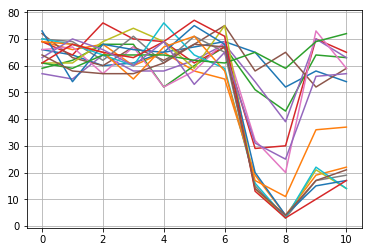

```
ae6a65ee4c6937be57199e7d585c22b3 => [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
501767cc2e6d32b6da0937159baf8760 => [16, 16, 16, 16, 16, 16, 16, 4, 1, 4, 4]
4f639c4609871298b6263fb1eee80e15 => [16, 16, 16, 16, 16, 16, 16, 12, 10, 16, 16]
39ec9e52f861104305dcf30e0b4d5411 => [16, 16, 16, 16, 16, 16, 16, 8, 7, 16, 16]
4f637811093320982c6d3fb12ae80e4d => [16, 15, 16, 16, 16, 16, 16, 12, 9, 16, 16]
3a1e3f8af3fd982102b115fa6d6e272d => [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
aa0fc624db0a178dabb9b5f956836b81 => [16, 16, 16, 16, 16, 16, 16, 8, 5, 16, 16]
50fe9ecc996232b6390937e99bafec6f => [16, 16, 16, 16, 16, 16, 16, 4, 1, 4, 4]
509f67cc876d32b6da0937fa9baf7a60 => [16, 16, 16, 16, 16, 16, 16, 4, 1, 4, 4]
50fe67c0996d95b6da8a37e943afec60 => [16, 16, 16, 16, 16, 16, 16, 4, 1, 4, 4]
50f067cc7f6d32b6da0937199bafd760 => [16, 15, 16, 16, 16, 16, 16, 4, 1, 4, 4]
cc6067ccd06d32cdda098b539bb93260 => [16, 16, 16, 16, 16, 16, 16, 4, 2, 8, 8]
3d025d025d025d025d025d025d025d02 => [16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16]
d4fe67cc996d329cda0940e99b71ec60 => [16, 16, 16, 16, 16, 16, 16, 4, 1, 4, 4]
0aeec0ccc8ee0525fc7168ba135f0ebc => [16, 16, 16, 16, 16, 15, 16, 8, 6, 15, 15]
50fec8cc998232b6620937e99bafeca3 => [16, 16, 16, 16, 16, 16, 16, 4, 1, 4, 4]
```

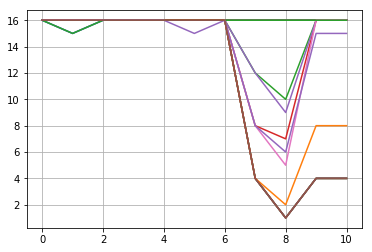